# Fine-Tuning Vision Transformers for Image Classification

Just as transformers-based models have revolutionized NLP, we're now seeing an explosion of papers applying them to all sorts of other domains. One of the most revolutionary of these was the Vision Transformer (ViT), which was introduced in [June 2021](https://arxiv.org/abs/2010.11929) by a team of researchers at Google Brain.

This paper explored how you can tokenize images, just as you would tokenize sentences, so that they can be passed to transformer models for training. Its quite a simple concept, really...

1. Split an image into a grid of sub-image patches
1. Embed each patch with a linear projection
1. Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)


It turns out that once you've done the above, you can pre-train and finetune transformers just as you're used to with NLP tasks. Pretty sweet 😎.

---

In this notebook, we'll walk through how to leverage 🤗 `datasets` to download and process image classification datasets, and then use them to fine-tune a pre-trained ViT with 🤗 `transformers`. 

To get started, lets first install both those packages.

In [1]:
import os
os.environ['PATH'] += ':/opt/bin'
!echo $PATH

/root/.vscode-server/bin/d6ee99e4c045a6716e5c653d7da8e9ae6f5a8b03/bin/remote-cli:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/opt/bin


In [2]:
!nvidia-smi

Wed Feb 16 06:02:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# blocks output in Colab 💄

! pip install datasets transformers

     |████████████████████████████████| 311 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 49.0 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 45.7 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 5.3 MB/s  eta 0:00:01
     |████████████████████████████████| 1.1 MB 39.8 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 52.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 30.9 MB/s eta 0:00:01
     |████████████████████████████████| 596 kB 42.6 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 32.9 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 271 kB 35.2 MB/s eta 0:00:01
     |████████████████████████████████| 144 kB 47.2 MB/s eta 0:00:01
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Load a dataset

Let's start by loading a small image classification dataset and taking a look at its structure.

We'll use the [`beans`](https://huggingface.co/datasets/beans) dataset, which is a collection of pictures of healthy and unhealthy bean leaves. 🍃

In [4]:
from datasets import load_dataset

ds = load_dataset('beans')
ds

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/144M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/d5abfbb94de45599d871182cff389bc870bf145b4829c4b0fe20f0cccd637cbd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

Let's take a look at the 400th example from the `train` split from the beans dataset. You'll notice each example from the dataset has 3 features:

1. `image`: A PIL Image
2. `image_file_path`: The `str` path to the image file that was loaded as `image`
3. `labels`: A [`datasets.ClassLabel`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel) feature, which we'll see as an integer representation of the label for a given example. (Later we'll see how to get the string class names, don't worry)

In [5]:
ex = ds['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7FB4D52B6790>,
 'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/0aaa78294d4bf5114f58547e48d91b7826649919505379a167decb629aa92b0a/train/angular_leaf_spot/angular_leaf_spot_train.344.jpg',
 'labels': 0}

Let's take a look at the image 👀

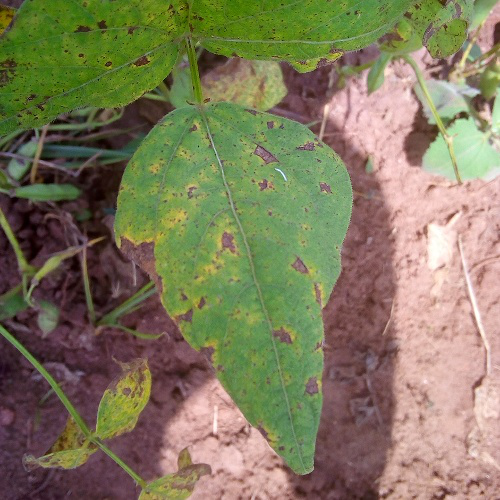

In [6]:
image = ex['image']
image

Thats definitely a leaf! But what kind? 😅
Since the `labels` feature of this dataset is a `datasets.features.ClassLabel`, we can use it to lookup the corresponding name for this example's label ID.

First, lets access the feature definition for the `labels`.

In [7]:
labels = ds['train'].features['labels']
labels

ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], names_file=None, id=None)

Now, lets print out the class label for our example. We'll do that by using the [`int2str`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) function of `ClassLabel`, which, as the name implies, lets us pass the int representation of the class to look up the string label.

In [8]:
labels.int2str(ex['labels'])

'angular_leaf_spot'

Turns out the leaf shown above is infected with Bean Rust, a serious disease in bean plants. 😢

Let's write a function that'll display a grid of examples from each class so we can get a better idea of what we're working with.

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

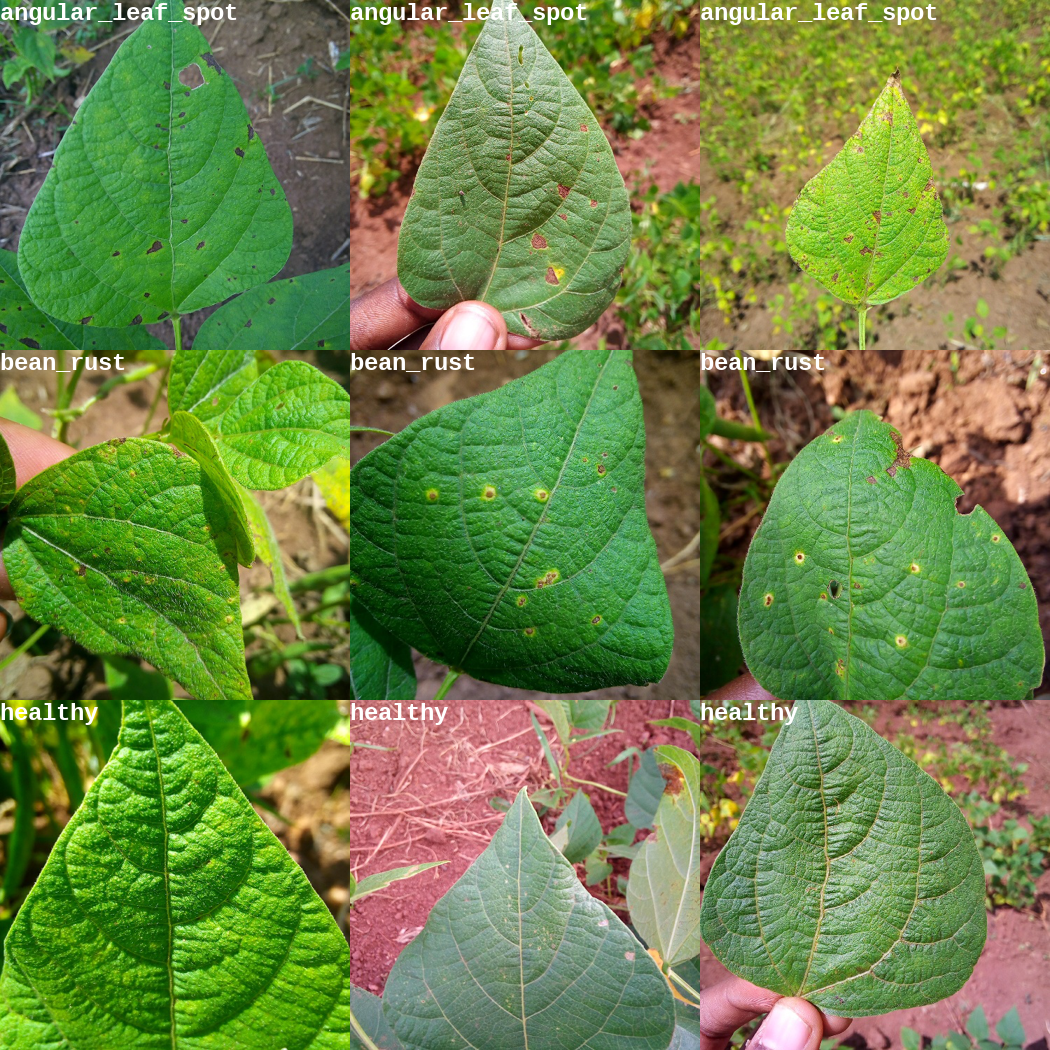

In [10]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def ShowExamples(_ds, _seed: int = 1234, _examplesPerClass: int = 3, _size=(350, 350)):
    w, h = _size
    labels = _ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(_examplesPerClass * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for labelID, label in enumerate(labels):
        # Filter the dataset by a single label, shuffle it, and grab a few samples
        dsSlice = ds['train'].filter(lambda ex: ex['labels'] == labelID).shuffle(_seed).select(range(_examplesPerClass))

        # Plot this label's examples along a row
        for i, example in enumerate(dsSlice):
            image = example['image']
            idx = _examplesPerClass * labelID + i
            box = (idx % _examplesPerClass * w, idx // _examplesPerClass * h)
            grid.paste(image.resize(_size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

ShowExamples(ds, _seed=random.randint(0, 1337), _examplesPerClass=3)

From what I'm seeing,
- Angular Leaf Spot: Has irregular brown patches
- Bean Rust: Has circular brown spots surrounded with a white-ish yellow ring
- Healthy: ...looks healthy. 🤷‍♂️

## Loading ViT Feature Extractor

Now that we know what our images look like and have a better understanding of the problem we're trying to solve, let's see how we can prepare these images for our model.

When ViT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing! 🖼 ➡️ 🔢

To make sure we apply the correct transformations, we will use a [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model, so lets load its feature extractor from the 🤗 Hub.

In [11]:
from transformers import ViTFeatureExtractor

modelNameOrPath = 'google/vit-base-patch16-224-in21k'
featureExtractor = ViTFeatureExtractor.from_pretrained(modelNameOrPath)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

If we print a feature extractor, we can see its configuration.

In [12]:
featureExtractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensorw='pt'` argument, we'll get back `torch` tensors instead.

In [13]:
featureExtractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.4510, -0.4353, -0.3961,  ...,  0.0588,  0.1922,  0.3882],
          [-0.3961, -0.4275, -0.4510,  ...,  0.1529,  0.3804,  0.5451],
          [-0.3725, -0.3569, -0.3725,  ...,  0.3804,  0.5608,  0.6549],
          ...,
          [-0.3804, -0.3804, -0.4196,  ...,  0.3412,  0.4118,  0.5137],
          [-0.3647, -0.4039, -0.4667,  ...,  0.4431,  0.4510,  0.5216],
          [-0.3647, -0.3961, -0.4196,  ...,  0.4275,  0.2627,  0.2078]],

         [[-0.5686, -0.5922, -0.5686,  ...,  0.2314,  0.2157,  0.3020],
          [-0.5373, -0.5843, -0.6000,  ...,  0.2235,  0.2627,  0.3255],
          [-0.5294, -0.5059, -0.4980,  ...,  0.3176,  0.3490,  0.3804],
          ...,
          [-0.6235, -0.6078, -0.6314,  ..., -0.0039,  0.0667,  0.1765],
          [-0.5765, -0.6157, -0.6784,  ...,  0.1059,  0.1216,  0.2000],
          [-0.5686, -0.6078, -0.6314,  ...,  0.0902, -0.0745, -0.1294]],

         [[-0.5373, -0.4667, -0.4431,  ..., -0.1843, -0.0667,  0.0980],
          [-0

## Processing the Dataset

Nowthat we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [16]:
def ProcessExample(_example):
    inputs = featureExtractor(_example['image'], return_tensors='pt')
    inputs['labels'] = _example['labels']

    return inputs

In [17]:
ProcessExample(ds['train'][0])

{'pixel_values': tensor([[[[ 0.3255,  0.2314,  0.2941,  ...,  0.5686,  0.4902,  0.0902],
          [ 0.4196,  0.3569,  0.3098,  ...,  0.5451,  0.4980,  0.0824],
          [ 0.4118,  0.4039,  0.4275,  ...,  0.4667,  0.5608,  0.1922],
          ...,
          [-0.4980, -0.4745, -0.5216,  ...,  0.4039,  0.2863,  0.2549],
          [-0.5216, -0.5451, -0.6157,  ...,  0.2863,  0.1765,  0.2314],
          [-0.5059, -0.5922, -0.5922,  ...,  0.2078,  0.1294,  0.1922]],

         [[-0.2784, -0.3725, -0.3255,  ...,  0.0118, -0.0980, -0.5216],
          [-0.1843, -0.2471, -0.3020,  ..., -0.0118, -0.0824, -0.5294],
          [-0.1765, -0.1922, -0.1765,  ..., -0.0745, -0.0196, -0.4196],
          ...,
          [-0.3569, -0.3412, -0.3961,  ...,  0.3569,  0.2784,  0.2549],
          [-0.3882, -0.4039, -0.4824,  ...,  0.2706,  0.2078,  0.2706],
          [-0.3725, -0.4510, -0.4588,  ...,  0.2000,  0.1765,  0.2549]],

         [[-0.3569, -0.4275, -0.3725,  ..., -0.2392, -0.2706, -0.6314],
          [-0

While we could call `ds.map` and apply this to every example at once, this can be very slow, expecially if you use a larger dataset. Instead, we'll apply a ***transform*** to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [18]:
ds = load_dataset('beans')

def Transform(_exampleBatch):
    # Take a list of PIL images and turn them to pixel values
    inputs = featureExtractor([x for x in _exampleBatch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = _exampleBatch['labels']
    return inputs

preparedDs = ds.with_transform(Transform)

Using custom data configuration default
Reusing dataset beans (/root/.cache/huggingface/datasets/beans/default/0.0.0/d5abfbb94de45599d871182cff389bc870bf145b4829c4b0fe20f0cccd637cbd)


  0%|          | 0/3 [00:00<?, ?it/s]

We can directly apply this to our dataset using `ds.with_transform(Transform)`.

In [19]:
preparedDs = ds.with_transform(Transform)

Now, whenever we get an example from the dataset, our transform will be applied in real time (on both samples and slices, as shown below)

In [20]:
preparedDs['train'][0:2]

{'pixel_values': tensor([[[[ 0.3255,  0.2314,  0.2941,  ...,  0.5686,  0.4902,  0.0902],
          [ 0.4196,  0.3569,  0.3098,  ...,  0.5451,  0.4980,  0.0824],
          [ 0.4118,  0.4039,  0.4275,  ...,  0.4667,  0.5608,  0.1922],
          ...,
          [-0.4980, -0.4745, -0.5216,  ...,  0.4039,  0.2863,  0.2549],
          [-0.5216, -0.5451, -0.6157,  ...,  0.2863,  0.1765,  0.2314],
          [-0.5059, -0.5922, -0.5922,  ...,  0.2078,  0.1294,  0.1922]],

         [[-0.2784, -0.3725, -0.3255,  ...,  0.0118, -0.0980, -0.5216],
          [-0.1843, -0.2471, -0.3020,  ..., -0.0118, -0.0824, -0.5294],
          [-0.1765, -0.1922, -0.1765,  ..., -0.0745, -0.0196, -0.4196],
          ...,
          [-0.3569, -0.3412, -0.3961,  ...,  0.3569,  0.2784,  0.2549],
          [-0.3882, -0.4039, -0.4824,  ...,  0.2706,  0.2078,  0.2706],
          [-0.3725, -0.4510, -0.4588,  ...,  0.2000,  0.1765,  0.2549]],

         [[-0.3569, -0.4275, -0.3725,  ..., -0.2392, -0.2706, -0.6314],
          [-0

# Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainder, but that'll require us to do a few things first:

- Define a collate function.
- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.
- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.
- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

## Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [21]:
import torch

def CollateFn(_batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in _batch]),
        'labels': torch.tensor([x['labels'] for x in _batch])
    }

## Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [22]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def ComputeMetrics(_p):
    return metric.compute(predictions=np.argmax(_p.predictions, axis=1), references=_p.label_ids)

Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [23]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    modelNameOrPath,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features 9'image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [24]:
from transformers import TrainingArguments

trainingArgs = TrainingArguments(
    output_dir="./vit-base-beans-demo-v5",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!

In [25]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=trainingArgs,
    data_collator=CollateFn,
    compute_metrics=ComputeMetrics,
    train_dataset=preparedDs['train'],
    eval_dataset=preparedDs['validation'],
    tokenizer=featureExtractor,
)

Using amp half precision backend


In [26]:
trainResults = trainer.train()
trainer.save_model()
trainer.log_metrics("train", trainResults.metrics)
trainer.save_metrics("train", trainResults.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260


Step,Training Loss,Validation Loss,Accuracy
100,0.079600,0.059921,0.984962
200,0.013500,0.039789,0.992481


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-100
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-100/config.json
Model weights saved in ./vit-base-beans-demo-v5/checkpoint-100/pytorch_model.bin
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-200
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-200/config.json
Model weights saved in ./vit-base-beans-demo-v5/checkpoint-200/pytorch_model.bin
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-200/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-base-beans-demo-v5/checkpoint-200 (score: 0.03978895768523216).
Saving model checkpoint to ./vit-base-beans-demo-v5
Configur

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1387
  train_runtime            =  0:11:05.61
  train_samples_per_second =       6.214
  train_steps_per_second   =       0.391


In [27]:
metrics = trainer.evaluate(preparedDs['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9925
  eval_loss               =     0.0398
  eval_runtime            = 0:00:07.87
  eval_samples_per_second =     16.885
  eval_steps_per_second   =      2.158


In [28]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'beans',
    "tags": ['image-classification'],
}

if trainingArgs.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

The resulting model has been shared to [nateraw/vit-base-beans](https://huggingface.co/nateraw/vit-base-beans). I'm assuming you don't have pictures of bean leaves laying around, but if you do, you can try out the model in the browser 🚀.